# Re-analysing ILL Y(Mn1-xFex)2 Data

This data was collected 15th July, 2000 (the logbook says 2002, I have no idea why, 2000 sounds right).  In those days, there was no event mode, so this analysis creates events by randomly smapling the histograms.  This is a good test of the method, because we already know what the traditional analysis shows, and we should be able to reproduce the result.

## Histogram Functions

The first step is to recreate a few of the basic workflow functions before we re-sample the histograms as events.

Some curiosities:
* The LAMP code s_normalise.pro, which normalises the data to monitor counts etc, multiplies the run counts by 1000 before dividing by the monitor counts.  This is odd.
* My radial average code is almost precisely 0.5 times the output of the ILL code, neglecting some small sampling errors and systematics.  A factor of 2 difference is always suspicious but I can't see where it is.  I use the same algorithm as in LAMP.
* It appears that the LAMP code from 20 years ago doesn't actually pay any attention to the perspex ("water") run (there is SANS in it and so a systematic error) or the cadmium run (the background is so small anyway you can just ignore it).
* My fits with lmfit produce different parameters with the same data.
* It looks like the LAMP code does not shift the x values to the histogram bin centre, but rather keeps the low-x edge.


In [225]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def plot_detector_map(data, log_scale=True):
    if log_scale:
        data = np.log(data)
    plt.imshow(data,  interpolation='nearest', cmap=cm.viridis)
    
def detector_distance_from(num):
    # Returns detector distance value from run
    path = "data/ill/d11/ymnfe2/"
    fnum = str(num).zfill(6)
    fullname = path + fnum
    
    datafile = open(fullname, 'r')
    lines=datafile.readlines()
    datafile.close()
            
    comment_block_length = 26
        
    detector_distance_line_index = [37+comment_block_length]
    detector_distance_line = [lines[i].strip() for i in detector_distance_line_index]
    detector_distance_index = 3
    det = np.float_( detector_distance_line[0].split("  ")[detector_distance_index] )
    
    return(det)

    
def wavelength_from(num):
    # Returns wavelength value from run
    path = "data/ill/d11/ymnfe2/"
    fnum = str(num).zfill(6)
    fullname = path + fnum
    
    
    datafile = open(fullname, 'r')
    lines=datafile.readlines()
    datafile.close()
 
    comment_block_length = 26
        
    wavelength_line_index = [44+comment_block_length]
        
    wavelength_line = [lines[i].strip() for i in wavelength_line_index]
        
    wavelength_index = 2
    wavelength = np.float_( wavelength_line[0].split("  ")[wavelength_index] )
    
    return wavelength
    
def temperature_from(num):
    path = "data/ill/d11/ymnfe2/"
    fnum = str(num).zfill(6)
    fullname = path + fnum
    
    
    datafile = open(fullname, 'r')
    lines=datafile.readlines()
    datafile.close()
        
    comment_block_length = 26
    temperature_line_index = [40+comment_block_length]
    temperature_line = [lines[i].strip() for i in temperature_line_index]        
    temperature_index = 0
        
    temp = np.float_( temperature_line[0].split("  ")[temperature_index] )

    return(temp)

    
def read_run(num, info=False, plot=False):
    # Reads an individual run in ancient ILL D11 format
    
    path = "data/ill/d11/ymnfe2/"
    fnum = str(num).zfill(6)
    fullname = path + fnum
    print(fullname)
    
    
    datafile = open(fullname, 'r')
    lines=datafile.readlines()
    meta_elements = [25, 26]
    meta = [lines[i].strip() for i in meta_elements]
        
    comment_block_length = 26
        
    detector_line_index = [34+comment_block_length]
    detector_distance_line_index = [37+comment_block_length]
    temperature_line_index = [40+comment_block_length]
    wavelength_line_index = [44+comment_block_length]
    collimation_line_index = [45+comment_block_length]
        
    detector_line = [lines[i].strip() for i in detector_line_index]
    detector_distance_line = [lines[i].strip() for i in detector_distance_line_index]
    temperature_line = [lines[i].strip() for i in temperature_line_index]
    wavelength_line = [lines[i].strip() for i in wavelength_line_index]
    collimation_line = [lines[i].strip() for i in collimation_line_index]
        
    detector_sum_index = 3
    monitor_sum_index = 4
    detector_distance_index = 3
    temperature_index = 0
    wavelength_index = 2
    collimation_index = 2
        
        
    detector_sum = np.float_( detector_line[0].split("  ")[detector_sum_index] )
    monitor_sum = np.float_( detector_line[0].split("  ")[monitor_sum_index] )
    det = np.float_( detector_distance_line[0].split("  ")[detector_distance_index] )
    temp = np.float_( temperature_line[0].split("  ")[temperature_index] )
    wavelength = np.float_( wavelength_line[0].split("  ")[wavelength_index] )
    collimation = np.float_( collimation_line[0].split("  ")[collimation_index] )
    
    datafile.close()

        
    if info:
        print(meta[0])
        print(meta[1])
        
        print("Det. sum:", detector_sum)
        print("Mon. sum:", monitor_sum)
        print("Det. distance:", det)
        print("Temp:", temp)
        print("Wavelength:", wavelength)
        print("Collimation:", collimation)

    
    
    # Get some info on run
    datafile = open(fullname, 'r')
    
    # Legacy ILL data for D11 has 118 header rows
    lines=datafile.readlines()[118:]#skiprows=118)
    

    
    datafile.close()
    
    
    # The data is a 64x64 detector, but the histo
    # counts are recorded with 10 columns in sequence
    # Probably a fortran thing from back in the day
    
    data = []
    
    for line in lines:
        data += line.strip().split(" ")
        
    # Now we have each histo entry space separated
    # but we also have a lot of empty values
    # Each space character was stored.  Remove empty entries
    sdata = list(filter(None, data))
    
    # Convert strings to numpy array of floats
    ndata = np.float_(sdata)
    
    # Re-arrange into 64x64 grid of detector pixels
    ndata = ndata.reshape(64,64)
    
    # plot if necessary
    if plot:
        plot_detector_map(ndata)
    
    # It looks like this is the correct orientation,
    # with gravity downwards, in plt.imshow.  No rotation 
    # is required.
    # This is an array with [y, x] indices starting top-left
    
    return ndata, detector_sum, monitor_sum


def read_sum(run1, run2, plot=True):
    # Reads multiple runs and sums up the data
    
    data, detector_sum, monitor_sum = read_run(run1, plot=False, info=False)
    
    for run in range(run1+1, run2+1):
        new_data, new_dsum, new_msum = read_run(run, plot=False, info=False)
        data = data + new_data
        detector_sum = detector_sum + new_dsum
        monitor_sum = monitor_sum + new_msum
        
    if plot:
        plot_detector_map(data)
    
    return data, detector_sum, monitor_sum
    
def event_resample(data, detector_distance, wavelength, beam_centre):
    # Takes D11 2d histogram, detector distance, and wavelength, and resamples
    # events from the matrix assuming all neutrons are at a central point in the
    # pixel
    
    # This is the alternative method to the radial average (see below) which
    # preseves the histogram structure
    
    # Note that pixels are arranged in (y, x) order, NOT (x, y)
    
    opp = np.zeros_like(data)
    
    for iy in range(0, 64):
        for ix in range(0, 64):
            yval = iy - beam_centre[1]
            xval = ix - beam_centre[0]
            opp[iy, ix] = np.sqrt(yval**2.0 + xval**2.0)
    
    tanq = 0.01 * opp / detector_distance
    two_theta = np.arctan(tanq)
    
    theta = 0.5 * two_theta
    
    qval = 4.0 * np.pi * np.sin(theta) / wavelength
    
    
    return qval
    
def bleed_mask(mask):
    # takes mask data and bleeds it one pixel over

    # Bleed in y direction positive
    for iy in range(0, 64):
        for ix in range(0, 64):
            if iy < 63:
                if mask[iy+1, ix] < 0.5:
                    mask[iy, ix] = 0.0
    
    # Bleed in y direction negative
    for iy in range(63, -1, -1):
        for ix in range(0, 64):
            if iy > 0:
                if mask[iy-1, ix] < 0.5:
                    mask[iy, ix] = 0.0
                    
    # Bleed in x direction positive
    for iy in range(0, 64):
        for ix in range(0, 64):
            if ix < 63:
                if mask[iy, ix+1] < 0.5:
                    mask[iy, ix] = 0.0
                    
    # Bleed in x direction negative
    for iy in range(0,64):
        for ix in range(63, -1, -1):
            if ix > 0:
                if mask[iy, ix-1] < 0.5:
                    mask[iy, ix] = 0.0
    
    return mask

def make_mask(water):
    # uses a water run to make a mask.  Manually masks edges of detector
    # Finds the beamstop area and the detector boundaries by average
    # comparison
    
    mask = np.ones_like(water)
    
    left_panel = water[12:50,1:20]
    right_panel = water[12:50,1:61]
    top_panel = water[1:12,20:50]
    bot_panel = water[50:61,20:50]
    trimmed = np.concatenate((\
        left_panel.flatten(),\
        right_panel.flatten(),\
        top_panel.flatten(),\
        bot_panel.flatten()))
    
    mask_mean = np.mean(trimmed)
    mask_stddev = np.std(trimmed)
        
    threshold = mask_mean - mask_stddev
    

    
    
    fail = water < threshold
    
    mask[fail] = 0.0    

    mask = bleed_mask(mask)

    # manual edges
    mask[:,0]=0.0
    mask[0,:]=0.0
    mask[:,63] = 0.0
    mask[63,:] = 0.0
    
    plot_detector_map(mask, log_scale=False)
    
    return mask
    

def radial_average(data, detector_distance, wavelength, beam_centre, nbins=64, xshift=False, plot=True, xmin=None, xmax=None, ymin=None, ymax=None):
    # Radially averages the data and converts to Q
    
    opp = np.zeros_like(data)
    
    for iy in range(0, 64):
        for ix in range(0, 64):
            yval = iy - beam_centre[1]
            xval = ix - beam_centre[0]
            opp[iy, ix] = np.sqrt(yval**2.0 + xval**2.0)
    
    tanq = 0.01 * opp / detector_distance
    two_theta = np.arctan(tanq)
    
    theta = 0.5 * two_theta
    
    qval = 4.0 * np.pi * np.sin(theta) / wavelength
    qmin = np.amin(qval)
    qmax = np.amax(qval)
    
    bins = np.linspace(qmin, qmax, nbins)
    
    # The normalisation factor for each bin is the radial average
    # of the q values (that just counts how many pixels fall in
    # each bin)
    
    norm_hst = np.histogram(qval, bins=bins)
    
    error_weight = np.sqrt(data * data)
    
    hst = np.histogram(qval, bins=bins, weights = data)
    
    err = np.histogram(qval, bins=bins, weights = error_weight)
    
    #err = err[0]
    err = np.sqrt(err[0])
    
    
    
    xvals = hst[1]
    
    # Shift the x values to bin-centre
    if xshift:
        print("Shifting x")
        dx = xvals[1]-xvals[0]
        xvals = xvals + 0.5*dx
    else:
        print("Not shifting x")
    
    xplot = xvals[:-1]
    
    yplot = hst[0] / norm_hst[0]
    err = err / norm_hst[0]
    
    
    
    if plot:    
        #plt.plot(xplot, yplot, ls='None', marker='o')
        plt.errorbar(xplot, yplot, yerr=err, ls='None', marker='o')
        plt.yscale('log')
        plt.xscale('log')
        if xmin != None and xmax != None:
            plt.xlim([xmin, xmax])
        if ymin != None and ymax != None:
            plt.ylim([ymin, ymax])
            
    # Trim the data to specified ranges
    if xmin != None and xmax != None:
        trim_mask_min = xplot > xmin
        trim_mask_max = xplot < xmax
        trim_mask = trim_mask_min & trim_mask_max
        
        
        
        xplot = xplot[trim_mask]
        yplot = yplot[trim_mask]
        err = err[trim_mask]
        
    
    return xplot, yplot, err
    
    
    
def apply_mask(data, mask, plot=True):
    # masks out the data and returns cleaned data
    new_data = data * mask
    
    if(plot):
        plot_detector_map(new_data)
    
    return new_data



def norm_water(data, water, data_mon=1.0, water_mon=1.0, divide=False, verbose=False, plot=True):
    # normalises the detector response efficiency based on water run
    
    num_pixels = np.float_(np.sum(water > 0.0))
    
    nanmask = water == 0.0
    
    water_scale = water_mon / data_mon
    
    water = water / water_scale
    
    water_sum = np.sum(water)
    
    water = num_pixels * water / water_sum
    
    if divide:
        water[nanmask] = 1.0
        new_data = data / water
    else:
        new_data = data * water

    
    if verbose:
        print("water scale:", water_mon / data_mon)
        np.set_printoptions(threshold=np.inf)
        print("water norm:")
        print(water)
        np.set_printoptions(threshold=1000)
    
    if(plot):
        plot_detector_map(new_data)
    
    return new_data
    
    
    
    
def find_centre(data):
    # Uses a TRANSMISSION RUN to find the beam centre
    # Weighted mean of pixel coordinate map
    
    # Arrays are indexed [y, x] with origin in top left
    # as plotted in matplotlib imshow
    
    yint = np.sum(data, axis=1) 
    xint = np.sum(data, axis=0)
    
    yint_sum = np.sum(yint)
    xint_sum = np.sum(xint)
        
    yint = yint / yint_sum
    xint = xint / xint_sum
    
    pixval = np.arange(0, 64)
    
    weightedx = pixval * yint
    weightedy = pixval * xint
    
    xcentre = np.sum(weightedx)
    ycentre = np.sum(weightedy)
    
    return np.array([xcentre, ycentre])
        

def calculate_transmission(air, sample, air_mon, sample_mon, verbose=True):
    
    spot_max = np.amax(air)
    
    spot_region = air > 0.05*spot_max
    
    air_clip = air[spot_region]
    sample_clip = sample[spot_region]
    
    airsum = np.sum(air_clip)
    ssum = np.sum(sample_clip)
    
    airsum_mon = airsum / air_mon
    ssum_mon = ssum / sample_mon
    
    transmission_mon = ssum_mon / airsum_mon
    transmission = ssum / airsum
    
    if verbose:
        print("airsum", airsum)
        print("ssum", ssum)
        print("airsum_mon", airsum_mon)
        print("ssum_mon", ssum_mon)
        print("transmission_mon", transmission_mon)
        print("transmission", transmission)
    
    
    
    return transmission
    

data/ill/d11/ymnfe2/006314
data/ill/d11/ymnfe2/006315


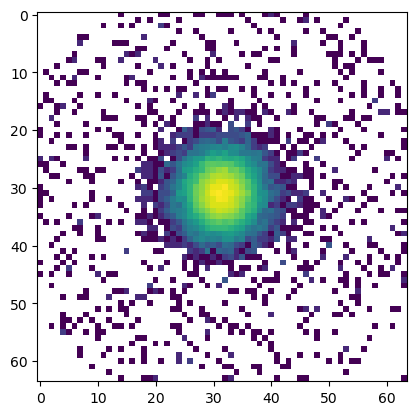

In [215]:
sample_trans, non1, sample_trans_mon = read_sum(6314, 6315, plot=True)

data/ill/d11/ymnfe2/006018


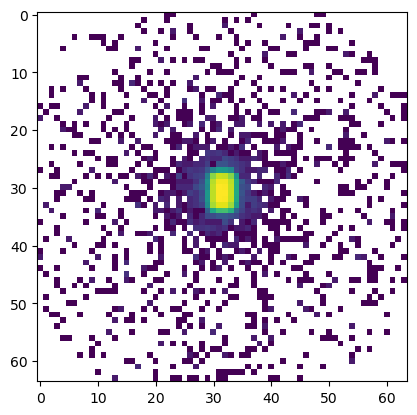

In [214]:
empty_trans, non1, empty_trans_mon = read_run(6018, plot=True)

In [226]:
trans = calculate_transmission(sample_trans, empty_trans, sample_trans_mon, empty_trans_mon)
print(trans)

airsum 18712.0
ssum 262984.0
airsum_mon 0.015593359322265537
ssum_mon 0.4383073971789953
transmission_mon 28.10859341598974
transmission 14.054296707994869
14.054296707994869


data/ill/d11/ymnfe2/006346


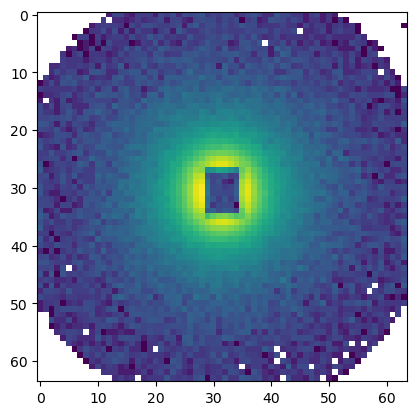

In [154]:
nuclear, non1, non2 = read_run(6346, plot=True)

data/ill/d11/ymnfe2/006025


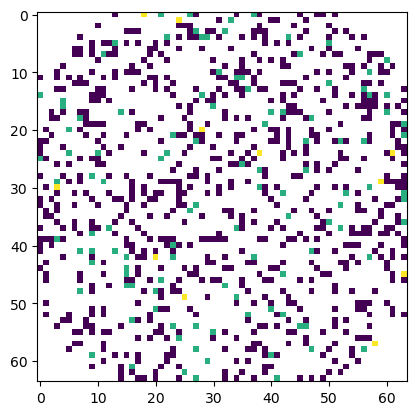

In [155]:
cadmium, non1, non2 = read_run(6025, plot=True)

data/ill/d11/ymnfe2/006010
data/ill/d11/ymnfe2/006011
data/ill/d11/ymnfe2/006012
data/ill/d11/ymnfe2/006013
data/ill/d11/ymnfe2/006014
data/ill/d11/ymnfe2/006015
data/ill/d11/ymnfe2/006016
data/ill/d11/ymnfe2/006017


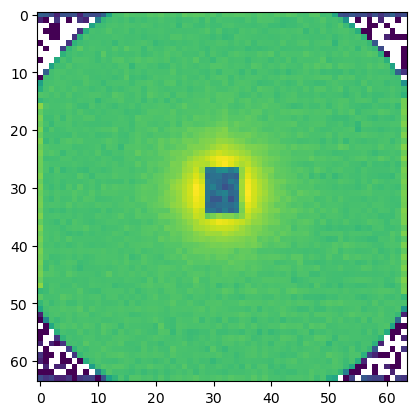

In [170]:
water, detsum, water_mon = read_sum(6010, 6017)
#water = water - cadmium

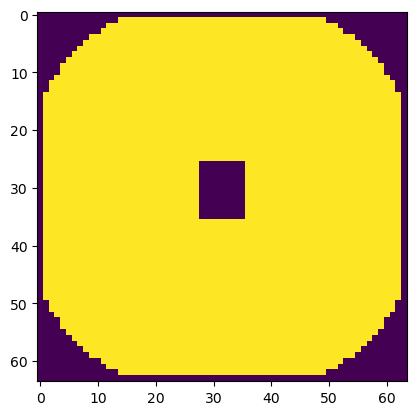

In [171]:
detector_mask = make_mask(water)

In [172]:
ctr_data, ss, mon = read_run(6314, info=True)
print(ss)
beam_centre = find_centre(ctr_data)
print(beam_centre)

data/ill/d11/ymnfe2/006314
Cywinski  ymnfe2                                 5-32-60877 YMnFe0.6 trans
18-JUN-00 22:18:36  18-JUN-00 22:21:43
Det. sum: 12405.0
Mon. sum: 599999.0
Det. distance: 9.9989996
Temp: 101.439003
Wavelength: 9.99982071
Collimation: 10.5
12405.0
[30.92261185 31.36130593]


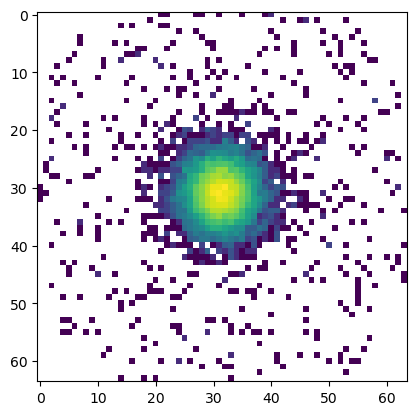

In [173]:
plot_detector_map(ctr_data)

In [174]:
realdat, detsum, data_mon = read_run(6316)
#realdat = realdat - cadmium
#realdat = realdat - nuclear

data/ill/d11/ymnfe2/006316


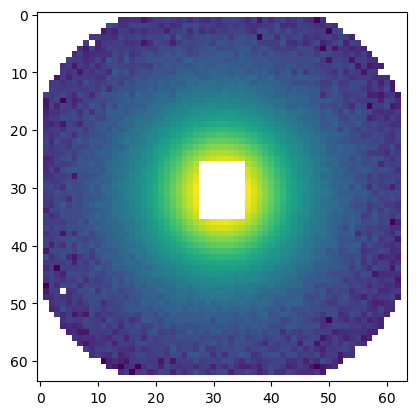

In [175]:
realdat_masked = apply_mask(realdat, detector_mask)

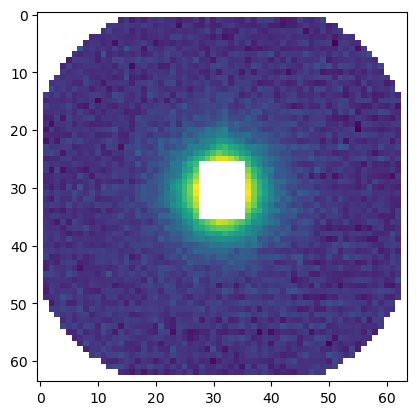

In [176]:
water_masked = apply_mask(water, detector_mask)

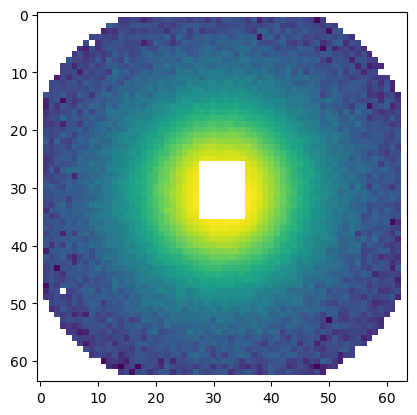

In [177]:
norm_realdat = norm_water(realdat_masked, water_masked, data_mon=data_mon, water_mon=water_mon)
norm_divide = norm_water(realdat_masked, water_masked, data_mon=data_mon, water_mon=water_mon, divide=True)

The following treatment reconstructs the ILL data using IDL (almost):
* No cadmium subtraction
* No detector efficiency / water calibration
* No shift in x values
* 55 data points in radial average

The anomalous feature of this is the appearance of a factor of 0.5 (or 2.0) in the scaling.  Must investigate.

Not shifting x
Not shifting x
Not shifting x


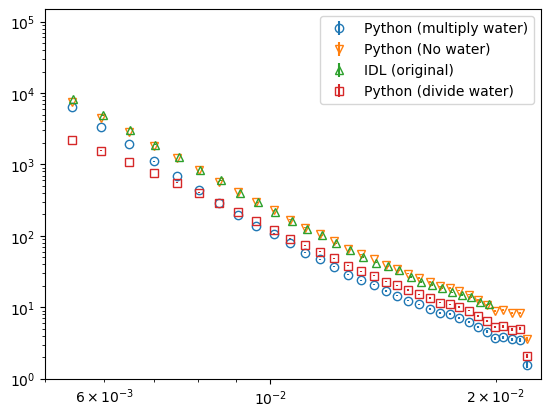

In [203]:
nbins=55

spec = radial_average(norm_realdat, detector_distance_from(6010), wavelength_from(6010), beam_centre, nbins=nbins, xshift=False, plot=False)#, xmin=0.0048, xmax=0.02, ymin=1.0, ymax=10000.0)

nowater=radial_average(2.0*realdat_masked, detector_distance_from(6010), wavelength_from(6010), beam_centre, nbins=nbins, xshift=False, plot=False)
divide =radial_average(norm_divide, detector_distance_from(6010), wavelength_from(6010), beam_centre, nbins=nbins, xshift=False, plot=False)

#check from existing data
old_data = np.loadtxt("/Users/phillipbentley/Experimental_Work/PhD/y(mnfe)2/SANS/xp6/ymnfep6_0.dat", unpack=True,max_rows=30)



fig, ax = plt.subplots()
ax.errorbar(spec[0], spec[1], spec[2], fmt='o', mfc='none', label="Python (multiply water)")
ax.errorbar(nowater[0], nowater[1], nowater[2], fmt='v', mfc='none', label="Python (No water)")
ax.errorbar(old_data[0], old_data[1], old_data[2], fmt='^', mfc='none', label="IDL (original)")
ax.errorbar(divide[0], divide[1], divide[2], fmt='s', mfc='none', label="Python (divide water)")
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim([0.005, 0.023])
plt.ylim([1.0, 150000.0])
ax.legend()

In [205]:
print(old_data[0][0])
print(nowater[0][8])
print(old_data[2][0])
print(nowater[2][8])
print()
print(old_data[2][20])
print(nowater[2][28])

0.004399
0.004386858746945491
41.061459
24.408433070114754

0.692626
0.5283927417649406


In [73]:
from lmfit import Model

def emulsion_ls_func(x, aa, kk, bb, cc, bg):
    first = aa / (kk*kk + x*x)
    second = bb / x**4.0
    third = cc / x**6.0
        
    return first + second + third + bg

emodel = Model(emulsion_ls_func)

params = emodel.make_params(\
    aa=dict(value=2.3E-3, min=0.0),\
    kk=dict(value=0.02),\
    bb=dict(value=2.0E-4, min=0.0),\
    cc=dict(value=1.5E-7, min=0.0),\
    bg=dict(value=1.0, min=0.0)\
           )

result = emodel.fit(spec[1], params, x=spec[0], weights = 1.0/spec[2])

print(result.fit_report())

fig, ax = plt.subplots()
ax.errorbar(spec[0], spec[1], spec[2], fmt='o', mfc='none', label="Data (hist)")
#ax.plot(spec[0], result.init_fit, '--', color='black', label="LSE initial")
ax.plot(spec[0], result.best_fit, color='black', label="LSE fit")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1278/1064181619.py:20: RuntimeWarning: divide by zero encountered in divide
  result = emodel.fit(spec[1], params, x=spec[0], weights = 1.0/spec[2])


ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

In [137]:
zeta = result.params["cc"].value / result.params["bb"].value
print(zeta)

0.004673556267781688


This doesn't match the value in the paper of 0.00044 (order of magnitude difference).  I think there is an extra correction going on with the data for transmission, which needs to be done next.

[[Model]]
    Model(emulsion_ls_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 30
    # variables        = 5
    chi-square         = 6746.09002
    reduced chi-square = 269.843601
    Akaike info crit   = 172.465629
    Bayesian info crit = 179.471616
    R-squared          = 0.99999112
[[Variables]]
    aa:  70811.6994 +/- 2.2347e+14 (315579781771.32%) (init = 0.0023)
    kk: -26028.6355 +/- 9.9223e+13 (381206775658.46%) (init = 0.02)
    bb:  9.1130e-07 +/- 1.9832e-07 (21.76%) (init = 0.0002)
    cc:  1.7172e-10 +/- 7.6544e-12 (4.46%) (init = 1.5e-07)
    bg:  0.00203632 +/- 821800.570 (40357150632.82%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kk, bg) = +0.9600
    C(bb, cc) = -0.8897
    C(aa, bg) = +0.7366
    C(aa, kk) = +0.5178
    C(kk, bb) = -0.4091
    C(kk, cc) = +0.4029
    C(bb, bg) = -0.3002
    C(aa, cc) = -0.2506
    C(cc, bg) = +0.2365


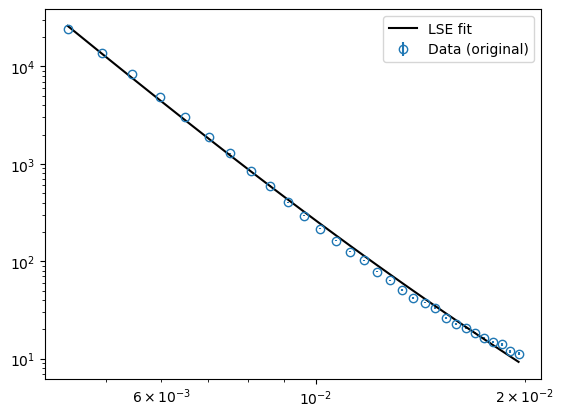

In [79]:
result = emodel.fit(old_data[1], params, x=old_data[0], weights = 1.0/old_data[2])

print(result.fit_report())

fig, ax = plt.subplots()
ax.errorbar(old_data[0], old_data[1], old_data[2], fmt='o', mfc='none', label="Data (original)")
#ax.plot(spec[0], result.init_fit, '--', color='black', label="LSE initial")
ax.plot(old_data[0], result.best_fit, color='black', label="LSE fit")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [80]:
zeta = result.params["cc"].value / result.params["bb"].value
print(zeta)

0.00018843286908107071


This implies also that the least squares algorithm in lmfit is different to the one in the other code.